**The objective of this assignment is build a data science model that explains how several factors impacted home prices over the last 20 years.**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_datareader import data as web
import datetime as dt

In [ ]:
#defining start and end date for our dataset for analysis of past 20 years data
start = dt.datetime(2004,2,1)
end = dt.datetime(2025,2,1)

In [ ]:
#importing S&P CoreLogic Case-Shiller U.S. National Home Price Index (CSUSHPISA) from FRED
index = web.DataReader("CSUSHPISA","fred",start, end)
index.columns = ["Index"]

In [ ]:

#understanding the dataset through exploratory data analysis
print(index.head())
print(index.tail())
print(index.info())
print(index.describe())

              Index
DATE               
2004-02-01  143.191
2004-03-01  145.058
2004-04-01  146.593
2004-05-01  148.186
2004-06-01  149.852
              Index
DATE               
2024-10-01  324.474
2024-11-01  326.005
2024-12-01  327.579
2025-01-01  329.408
2025-02-01  330.245
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2004-02-01 to 2025-02-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Index   253 non-null    float64
dtypes: float64(1)
memory usage: 4.0 KB
None
            Index
count  253.000000
mean   196.817289
std     55.746267
min    136.526000
25%    155.601000
50%    179.110000
75%    212.772000
max    330.245000


In [ ]:
#similarly importing all other datasets affecting housing prices in USA
income = web.DataReader("MEHOINUSA672N","fred",dt.datetime(2003,4,1), end) #since yearly data, so a year back data required for interpolation from 2004
population = web.DataReader("POP","fred",start, end)
mortgage = web.DataReader("MORTGAGE30US","fred",start, end)
un_rate = web.DataReader("UNRATE","fred",start, end)
gdp = web.DataReader("GDP","fred",dt.datetime(2004,1,1), end)
inflation = web.DataReader("CPIAUCNS","fred",start, end)

In [ ]:
#for S&P500 we will use yahoo fincance as it is not fully available on FRED
import yfinance as yf

#Download S&P 500 data from yahoo finance
sp500 = yf.download('^GSPC', start, end, interval='1mo')

NameError: name 'start' is not defined

In [ ]:
#adjusting the rows to uniformity
index = index[:-1]
population = population[:-1]
un_rate = un_rate[:-1]
inflation = inflation[:-1]

NameError: name 'index' is not defined

**We now know that these datasets have diffrent time intervals :
1)CSUSHPISA - Monthly,
2)MEHOINUSA672N - Yearly,
3)Population - Monthly,
4)Mortgage rates - weekly,
5)Unemployement rate - Monthly
6)GDP - Quaterly
7)Inflation - Monthly
8)SP500 - Daily**

In [ ]:
income = income.resample('MS').asfreq()

#interpolating values linearly
income['MEHOINUSA672N'] = income['MEHOINUSA672N'].interpolate(method='linear')

#aligning start month to feb as other datasets
income = income.iloc[1:]
#converting income to monthly income to align with the dataset
monthly_income = []

for i in income['MEHOINUSA672N']:
  i = i/12
  monthly_income.append(i)

income['MEHOINUSA672N'] = monthly_income

In [ ]:
#data only till 2023
income

,MEHOINUSA672N
DATE,
2004-02-01,5694.861111
2004-03-01,5702.222222
2004-04-01,5709.583333
2004-05-01,5716.944444
2004-06-01,5724.305556
...,...
2022-09-01,6632.222222
2022-10-01,6653.541667
2022-11-01,6674.861111


In [ ]:
#Use 'Close' price and rename "close" to "sp500" for clarity
sp500 = sp500[['Close']].rename(columns={'Close': 'SP500'})
sp500.index.name = 'Date'

#set to month-start to match other series of our dataset
sp500.index = sp500.index.to_period('M').to_timestamp()
sp500.columns = sp500.columns.get_level_values(0)

In [ ]:
sp500.round(1)

Price,SP500
Date,
2004-02-01,1144.9
2004-03-01,1126.2
2004-04-01,1107.3
2004-05-01,1120.7
2004-06-01,1140.8
...,...
2024-09-01,5762.5
2024-10-01,5705.5
2024-11-01,6032.4


In [ ]:
#GDP dataset from quaterly to monthly timeframe
monthly_index = pd.date_range(start=gdp.index.min(), end=gdp.index.max(), freq='MS')

gdp_monthly = gdp.reindex(monthly_index)

gdp_monthly = gdp_monthly.interpolate(method='linear')

gdp_monthly = gdp_monthly.round(1)
gdp_monthly = gdp_monthly.iloc[1:]
#renaming gdp_monthly to gdp
gdp = gdp_monthly

In [ ]:
#gdp Preview
print(gdp.head(12))
print(gdp.tail(12))

                GDP
2004-02-01  11986.6
2004-03-01  12049.7
2004-04-01  12112.8
2004-05-01  12177.0
2004-06-01  12241.1
2004-07-01  12305.3
2004-08-01  12379.3
2004-09-01  12453.2
2004-10-01  12527.2
2004-11-01  12607.2
2004-12-01  12687.3
2005-01-01  12767.3
                GDP
2024-02-01  28755.0
2024-03-01  28885.8
2024-04-01  29016.7
2024-05-01  29136.1
2024-06-01  29255.5
2024-07-01  29374.9
2024-08-01  29491.2
2024-09-01  29607.5
2024-10-01  29723.9
2024-11-01  29808.5
2024-12-01  29893.0
2025-01-01  29977.6


In [ ]:
#converting weekly data for mortgage rates to monthly dataset keeping first value of the month
mortgage = mortgage.resample('M').first()

#changing month end date to month start date to align with other datasets
mortgage.index = mortgage.index - pd.offsets.MonthEnd(1) + pd.offsets.MonthBegin(1)

print(mortgage.head())
print(mortgage.tail())

            MORTGAGE30US
DATE                    
2004-02-01          5.72
2004-03-01          5.59
2004-04-01          5.52
2004-05-01          6.12
2004-06-01          6.28
            MORTGAGE30US
DATE                    
2024-09-01          6.35
2024-10-01          6.12
2024-11-01          6.79
2024-12-01          6.69
2025-01-01          6.91


<ipython-input-90-7a1d96b4b4cb>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  mortgage = mortgage.resample('M').first()


In [ ]:
print(index.head())
print(income.head())
print(population.head())
print(mortgage.head())
print(un_rate.head())
print(gdp.head())
print(inflation.head())
print(sp500.head())

              Index
DATE               
2004-02-01  143.191
2004-03-01  145.058
2004-04-01  146.593
2004-05-01  148.186
2004-06-01  149.852
            MEHOINUSA672N
DATE                     
2004-02-01    5694.861111
2004-03-01    5702.222222
2004-04-01    5709.583333
2004-05-01    5716.944444
2004-06-01    5724.305556
                 POP
DATE                
2004-02-01  292368.0
2004-03-01  292561.0
2004-04-01  292779.0
2004-05-01  292997.0
2004-06-01  293223.0
            MORTGAGE30US
DATE                    
2004-02-01          5.72
2004-03-01          5.59
2004-04-01          5.52
2004-05-01          6.12
2004-06-01          6.28
            UNRATE
DATE              
2004-02-01     5.6
2004-03-01     5.8
2004-04-01     5.6
2004-05-01     5.6
2004-06-01     5.6
                GDP
2004-02-01  11986.6
2004-03-01  12049.7
2004-04-01  12112.8
2004-05-01  12177.0
2004-06-01  12241.1
            CPIAUCNS
DATE                
2004-02-01     186.2
2004-03-01     187.4
2004-04-01     188.

In [ ]:
print(index.tail())
print(income.tail())
print(population.tail())
print(mortgage.tail())
print(un_rate.tail())
print(gdp.tail())
print(inflation.tail())
print(sp500.tail())

              Index
DATE               
2024-09-01  323.281
2024-10-01  324.474
2024-11-01  326.005
2024-12-01  327.579
2025-01-01  329.408
            MEHOINUSA672N
DATE                     
2022-09-01    6632.222222
2022-10-01    6653.541667
2022-11-01    6674.861111
2022-12-01    6696.180556
2023-01-01    6717.500000
                   POP
DATE                  
2024-09-01  340734.171
2024-10-01  340916.485
2024-11-01  341088.462
2024-12-01  341249.828
2025-01-01  341390.432
            MORTGAGE30US
DATE                    
2024-09-01          6.35
2024-10-01          6.12
2024-11-01          6.79
2024-12-01          6.69
2025-01-01          6.91
            UNRATE
DATE              
2024-09-01     4.1
2024-10-01     4.1
2024-11-01     4.2
2024-12-01     4.1
2025-01-01     4.0
                GDP
2024-09-01  29607.5
2024-10-01  29723.9
2024-11-01  29808.5
2024-12-01  29893.0
2025-01-01  29977.6
            CPIAUCNS
DATE                
2024-09-01   315.301
2024-10-01   315.664
2024-

Now our all datasets are aligned with monthly requency and ready for data analysis.

In [ ]:
df = pd.concat([index, income, population, mortgage, un_rate, gdp, inflation, sp500], axis=1)

In [ ]:
#checking correlation of features with Index
correlations = df.corr(numeric_only=True)  # Compute correlation matrix
index_corr = correlations['Index'].drop('Index')  # Drop self-correlation

#sort in descending correlated order
index_corr_sorted = index_corr.sort_values(ascending=False)
print(index_corr_sorted)

SP500            0.950374
GDP              0.924083
CPIAUCNS         0.890693
MEHOINUSA672N    0.846393
POP              0.768526
MORTGAGE30US     0.259024
UNRATE          -0.570456
Name: Index, dtype: float64


Top correlating factors with index are **S&P500, GDP, inflation, median housing income and Population**        
*Mortgage Rates* are showing less correlation which may be due to lag effect where the housing prices are affected after certain time period by changes in Mortgage rates.                 
**Unemployment rates** are inversely correlated which was expected logically.

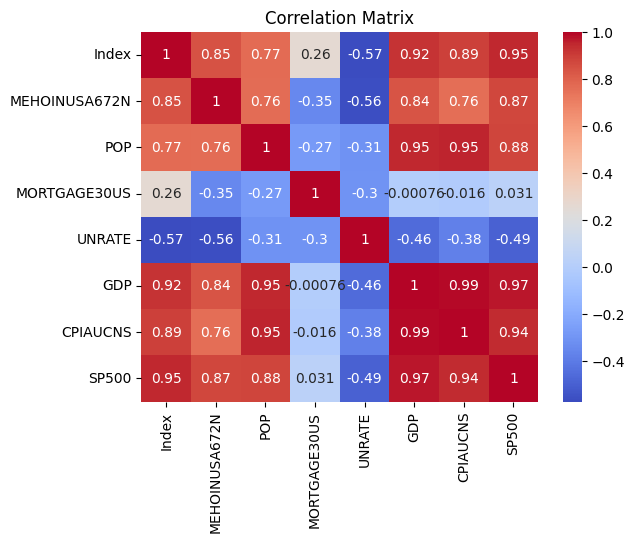

In [ ]:
#visualization of correlation
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [ ]:
#checking features with less correlation using lagging them with respect to out target column 'Index'
for i in range(13):
  df['MORTGAGE30US_lag'] = df['MORTGAGE30US'].shift(i)
  # Drop rows with NaNs caused by shifting
  df_lagged = df.dropna()
  # Now you can run correlation or regression using these lagged features
  corr_lagged = df_lagged[['Index', 'MORTGAGE30US_lag']].corr()
  print(corr_lagged, i)

                     Index  MORTGAGE30US_lag
Index             1.000000         -0.167291
MORTGAGE30US_lag -0.167291          1.000000 0
                     Index  MORTGAGE30US_lag
Index             1.000000         -0.207895
MORTGAGE30US_lag -0.207895          1.000000 1
                     Index  MORTGAGE30US_lag
Index             1.000000         -0.250317
MORTGAGE30US_lag -0.250317          1.000000 2
                     Index  MORTGAGE30US_lag
Index             1.000000         -0.300242
MORTGAGE30US_lag -0.300242          1.000000 3
                     Index  MORTGAGE30US_lag
Index             1.000000         -0.347521
MORTGAGE30US_lag -0.347521          1.000000 4
                     Index  MORTGAGE30US_lag
Index             1.000000         -0.382052
MORTGAGE30US_lag -0.382052          1.000000 5
                    Index  MORTGAGE30US_lag
Index             1.00000          -0.40821
MORTGAGE30US_lag -0.40821           1.00000 6
                     Index  MORTGAGE30US_lag

Mortgage rates shows lagging effect, more lagged data shows higher correlation, but lets keep unlagged mortgage rates in our futher model due to uncertainity of convergence

**Feature Selection**

In [ ]:
# Replace inf with NaN
df_cleaned = df.replace([np.inf, -np.inf], np.nan)
# Drop rows where Index is missing
df_cleaned = df_cleaned.dropna(subset=['Index'])
df_cleaned = df_cleaned.dropna()

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = add_constant(df_cleaned)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

            Feature           VIF
0             const  53877.955448
1             Index     49.152576
2     MEHOINUSA672N     19.841351
3               POP    132.942324
4      MORTGAGE30US      7.179997
5            UNRATE      3.279966
6               GDP    376.708019
7          CPIAUCNS    185.781871
8             SP500     44.211706
9  MORTGAGE30US_lag      6.596340


POP, GDP, SP500 and CPIAUCNS shows very high VIF, so we can keep only one of them which is SP500.        
MEHOINUSA672N, MORTGAGE30US and UNRATE shows less VIF so we can keep all of them and train model with them to overcome overfitting

In [ ]:
#model for prediction
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

Model Accuracy test based on diffrent set of features

**1) Calculating accuracy using all features**

In [ ]:
#Use all features
all_features = ['UNRATE', 'POP','MORTGAGE30US','GDP', 'MEHOINUSA672N', 'CPIAUCNS','SP500']
target_variable = 'Index'

# 📦 Drop rows with missing values (in case any remain)
df_model = df_cleaned[[target_variable] + all_features].dropna()

# 📊 Split into features (X) and target (y)
X = df_model[all_features]
y = df_model[target_variable]
# 🔀 Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 📈 Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# 📉 Predict
y_pred = model.predict(X_test)

# 📋 Evaluation
print("R² Score:", r2_score(y_test, y_pred))

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)
#Optional: Coefficients for interpretation
coefficients = pd.Series(model.coef_, index=all_features)
print("\nFeature Coefficients:\n", coefficients)

R² Score: 0.9739365700471966
RMSE: 6.520156585969358

Feature Coefficients:
 UNRATE           1.327007
POP             -0.004142
MORTGAGE30US     3.127049
GDP              0.014838
MEHOINUSA672N    0.024663
CPIAUCNS         0.167414
SP500            0.018415
dtype: float64


R² Score: 0.974                
RSME : 6.52 (AVG prediction error is 6.52 index points which is ~3% of index value, considering average of index ~230 points)

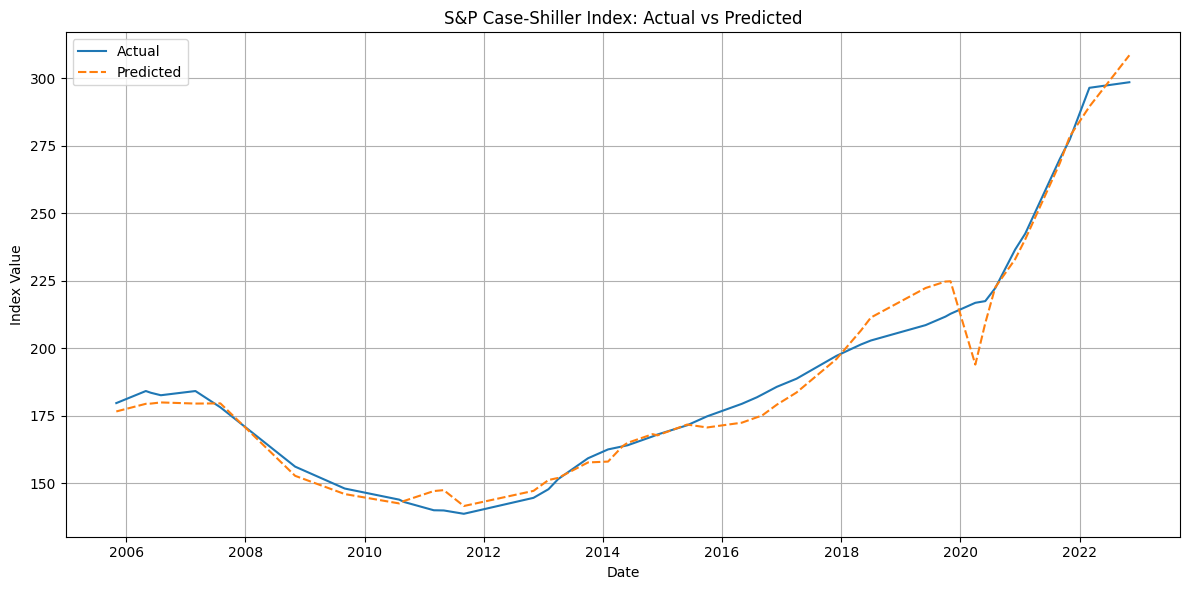

In [ ]:
# Create a DataFrame for actual vs predicted values
results = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
}, index=y_test.index)

# Sort by index (i.e., by date)
results = results.sort_index()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=results)
plt.title('S&P Case-Shiller Index: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.grid(True)
plt.tight_layout()
plt.show()

**2) Calculating error using selected features based on low VIF**

In [ ]:
# 📌 Use selected features based on low VIF
selected_features = ['UNRATE', 'MORTGAGE30US', 'MEHOINUSA672N', 'SP500']
target_variable = 'Index'

# 📦 Drop rows with missing values (in case any remain)
df_model = df_cleaned[[target_variable] + selected_features].dropna()

# 📊 Split into features (X) and target (y)
X = df_model[selected_features]
y = df_model[target_variable]
# 🔀 Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 📈 Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# 📉 Predict
y_pred = model.predict(X_test)

# 📋 Evaluation
print("R² Score:", r2_score(y_test, y_pred))

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)
#Optional: Coefficients for interpretation
coefficients = pd.Series(model.coef_, index=selected_features)
print("\nFeature Coefficients:\n", coefficients)

R² Score: 0.9645063955344052
RMSE: 7.60881971907547

Feature Coefficients:
 UNRATE            0.531565
MORTGAGE30US     15.326624
MEHOINUSA672N     0.007003
SP500             0.044078
dtype: float64


R² Score: 0.965                
RSME : 7.61 (AVG prediction error is 7.61 index point using selected features)

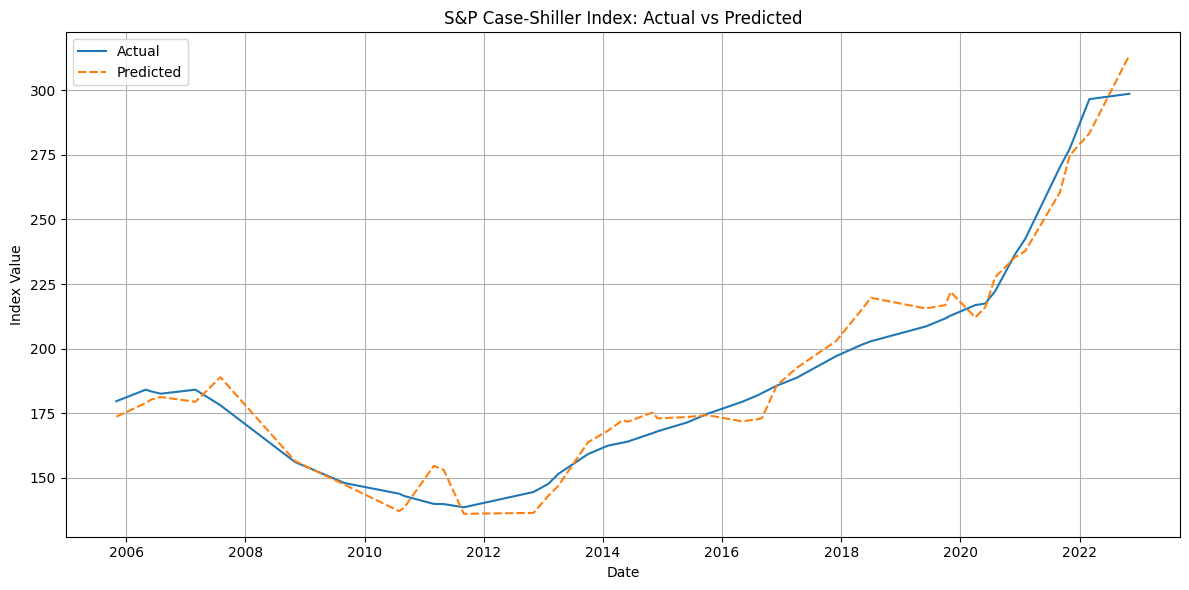

In [ ]:
# Create a DataFrame for actual vs predicted values
results = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
}, index=y_test.index)

# Sort by index (i.e., by date)
results = results.sort_index()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=results)
plt.title('S&P Case-Shiller Index: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.grid(True)
plt.tight_layout()
plt.show()

Upon evaluating two linear regression models to understand which set of predictors explains changes in the S&P Case-Shiller Home Price Index better:      
1) Using all features - R² Score: 0.974 and RSME: 6.52    
2) Using selected 4 features based on low VIF - R² Score: 0.965 and RSME:7.61                              
The full-feature model shows slightly better accuracy, indicating that features like GDP, CPI, and Population provide slight better prediction. However, the performance gain is not so high (about 1% improvement in R² and 1-point reduction in RMSE). So, from model scalability point better cost–accuracy trade-off is achieved in second model where less variables are required saving data collection cost and running time.

**SUMMARY** - Successfully built data science model model that explains housing prices over past 20 years.Used various datasets which we expected to impact housing prices over past several years.           
Two models were evaluated - 1) using all features and 2) using selected features based on Low VIF                  
Compared r_squared error and RMSE in both and recommended second model through cost - accuracy tradeoff. Second model contains key factors of housing prices — interest rates, unemployment, income, and market trends and avoids any overfitting.